In [121]:
%run functions.py
%run plot_functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import product

from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Load settings

In [122]:
pd.set_option('display.max_colwidth',-1)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use

score_function = f_regression # Score function for Feature selection
feature_tot = 0 # Total selected features -> Start at 0 before PCA
scoring='neg_mean_squared_error' # Scoring method for GridsearchCV

np.random.seed(seed) # Define the random seed


# Task 1 - Regression 

## Load dataset

In [123]:
filename = "datasets/cnDieselTrain.mat"

mat = loadmat(filename)
input_train = mat['cnTrainX'].T

target_train = mat['cnTrainY'].reshape(len(input_train))
input_test = mat['cnTestX'].T

## Data info

In [124]:
# The shape should look like (401,133) where 401 is the number of features and 133 is each row
print("Length of",len(input_train))
print("X.shape:", input_train.shape, "y.shape:", target_train.shape)    
print("Contains Nan:",np.isnan(input_train).any(), np.isnan(target_train).any())
print("Contains +inf:",np.isinf(input_train).any(),np.isinf(target_train).any())
print("Contains -inf:",np.isneginf(input_train).any(),np.isneginf(target_train).any())
#pd.DataFrame(input_train).describe()

Length of 133
X.shape: (133, 401) y.shape: (133,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [125]:
input_train_copy = deepcopy(input_train)

# In case one-hot
if len(target_train.T) == 3:
    for index,item in enumerate(target_train):
        item[0] = int("".join(str(x) for x in item), 2)
    

# Normalizing data
scaler = StandardScaler()
scaler.fit(input_train,y=target_train)

input_train_copy_normalized = deepcopy(input_train_copy)

input_train = scaler.transform(input_train)
input_test = scaler.transform(input_test)

## Feature reduction
Reduce dimensionality by PCA transform

In [126]:
pca = PCA(n_components = .95, svd_solver = 'full')
pca.fit(input_train,y=input_train)

pca_input = pca.transform(input_train)

feature_tot = len(pca_input[0])
print("original shape:   ", input_train_copy.shape)
print("transformed shape:", pca_input.shape)
print("Explained variance:",pca.explained_variance_ratio_)

original shape:    (133, 401)
transformed shape: (133, 7)
Explained variance: [0.44006606 0.20850319 0.15866727 0.08548419 0.04025895 0.01514767
 0.00792292]


# Plot PCA

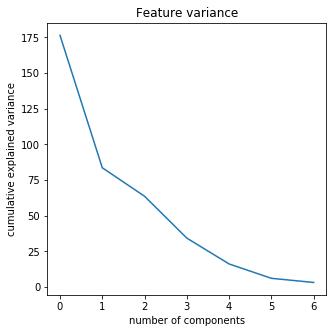

In [127]:
from math import ceil

cntItems = 1
rowItems = 1
fig, ax = plt.subplots(cntItems,rowItems,figsize=(5,5))

if cntItems == 1: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))

# Plot feature variance
plt.title("Feature variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
feature_variance = np.var(pca_input, 0)
plt.plot(feature_variance)

plt.show()



## Plot top 10 histogram over reduced features

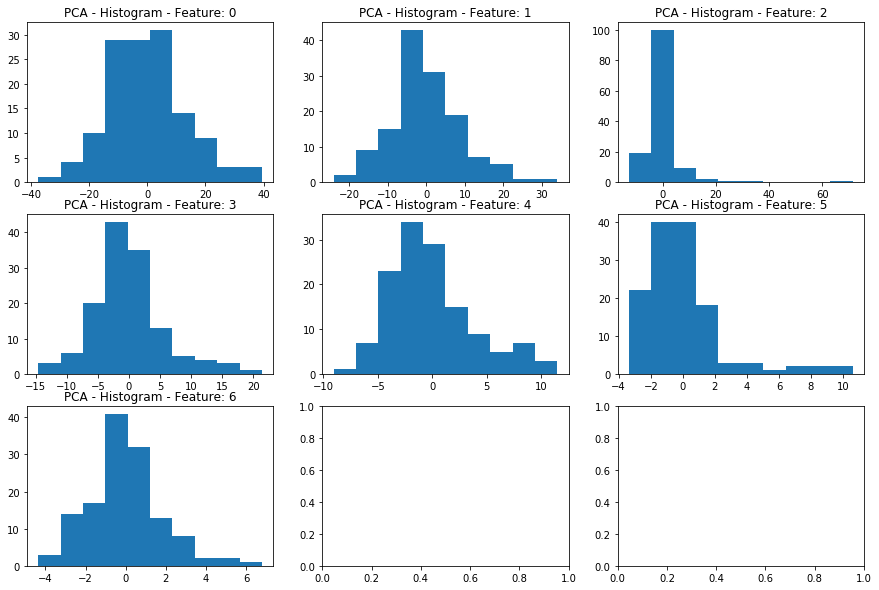

In [128]:
from math import ceil
startpos = 1
cntPlots = length if (length := feature_tot) <= 9 else 9
rowItems = 3
cntItems = ceil(cntPlots/rowItems)

fig, ax = plt.subplots(cntItems,rowItems,figsize=(15,10))
if cntItems == 0: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))


for index in range(0,(cntPlots)):
    ax[axlist[index]].set_title("PCA - Histogram - Feature: " + str(index))
    ax[axlist[index]].hist(pca_input[:,index])
    
plt.show()

# Feature selection
Extract top features above depending on PCA

(133, 401)


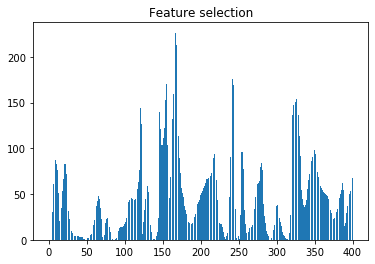

In [129]:
# Using amount of features based on PCA information
fs = SelectKBest(score_func=score_function, k=feature_tot)
fs.fit(input_train, target_train)
input_train_fs = fs.transform(input_train)
input_test_fs = fs.transform(input_test)

print(input_train_fs.shape)
plt.title("Feature selection")
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Hyperparameter tuning

In [130]:
#https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/


from sklearn.linear_model import Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve,validation_curve

N_FEATURES_COMPONENT = np.arange(2,10,2)

feature_select = [
        #PCA(iterated_power=N_FEATURES_COMPONENT), 
        #SelectKBest(f_regression),
        #ExtraTreesRegressor(random_state=seed, n_estimators=250),
        #RFE(RandomForestRegressor())
    ]


# GridSearchCV
estimators = [
    ('clf', SVR()),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,5000,10000],
}]


pipeline = Pipeline(estimators)
grid = GridSearchCV(
    pipeline,
    cv=k, 
    param_grid=param_grid,
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    scoring=scoring
) 
grid.fit(input_train_fs,target_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'clf': [SVR(C=1.0, cache_size=200, coef0=0.0,
                                      degree=3, epsilon=0.1, gamma='scale',
                                      k...
                         {'clf': [ElasticNet(alpha=0.1, copy_X=True,
                                             fit_intercept=True, l1_ratio=0.5,
                                             max_iter=5000, normalize=False,
 

## Get Model info

In [131]:
param_cols = ['']
score_cols = ['mean_train_score', 'std_test_score','mean_test_score', 'std_test_score']

grid_df = pd.DataFrame(grid.cv_results_, columns=score_cols)
grid_df.sort_values(by=['mean_test_score']).tail()
#print(grid_df)

print(f"Best score: {grid.best_score_}\nBest params {grid.best_params_}")

Best score: -4.908993087999625
Best params {'clf': ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=5000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 'clf__alpha': 0.1, 'clf__max_iter': 5000}


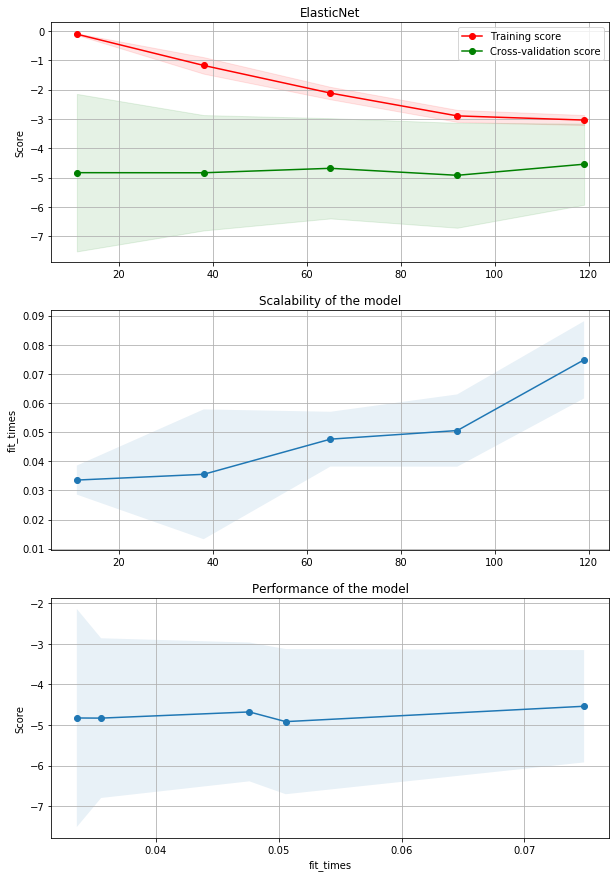

In [132]:
# Parameter to
param_range = np.arange(0.01, 50,5)
model = grid.best_params_['clf']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_learning_curve(model, model.__class__.__name__, input_train, target_train, axes=axes[:], cv=k, scoring=scoring, n_jobs=-1)
plt.show()

# Predict testset

In [133]:
model = grid.best_params_['clf']
model.fit(input_train_fs, target_train)
model.predict(input_test_fs)

array([49.80839109, 48.31626423, 47.7240841 , 48.79779241, 49.32478612,
       49.5632713 , 51.43151285, 48.26818754, 52.82940486, 53.69245789,
       48.88093308, 53.16619692, 52.98108912, 48.24416495, 46.6059743 ,
       51.14407191, 59.02349186, 47.81136857, 49.24498097, 46.21095806,
       49.76510706, 47.70049171, 43.7729782 , 49.81414554, 46.09856706,
       49.77250418, 50.37676037, 44.71325996, 46.99521295, 50.40544676,
       49.91020982, 47.3477196 , 47.39899864, 49.97092624, 50.98829958,
       47.66799938, 49.37139829, 49.96258446, 45.26677239, 46.10850057,
       46.12909505, 48.73852269, 48.91667255, 47.21477971, 46.92888215,
       52.19688962, 48.07887259, 45.14953753, 46.84207372, 43.07631747,
       47.15134273, 49.57506569, 46.57427347, 47.91314251, 46.76807307,
       47.93700816, 46.38314315, 47.84570432, 50.00650078, 49.09051146,
       46.77692973, 48.40917942, 47.67432276, 46.67395326, 47.51321552,
       47.74744518, 50.87301452, 52.44744729, 52.92507224, 51.31